# Import Function

In [1]:
import sys
sys.path.append('C://Users/Administrator/Desktop/packages/lzp_utils')

In [2]:
pwd

'E:\\zipeng.lin\\20190122_cscore_v1'

In [3]:
from import_packages import *
from tools import *
from sample_exploration import get_od_label
from data_aggregation import *
from data_cleaning import DATA_FILTER
from sample_exploration import get_pos_rate,desc_stat,feats_coverage_stat,sample_coverage_stat
from sample_splitter import SAMPLE_SPLITTER
from feature_transformation import UD_TRANSFORMER
from feature_trimming import UD_TRIMMER
from feature_scaling import UD_SCALER
from feature_encoding import UD_FEATURE_ENCODER
from feature_imputation import UD_IMPUTER
from feature_selection import FEATURE_FILTER
from feature_evaluation import get_vif_cor, plot_hist_all
from model_training import BAYSIAN_OPTIMIZATION, cv_check, xgbt, model_toolkit, model_selection
from model_evaluation import plot_all_figures
from recoding_statement import generate_recoding_statement

D:\Softwares\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
D:\Softwares\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Import Data

In [4]:
path = "E://zipeng.lin/20190122_cscore_v1/data/"


## Import Data

In [39]:
df = df_ori = pd.read_csv(path + 'maimaiche_data.csv', encoding='utf-8', sep='	')
del df['Unnamed: 0']
df = df[df.label != -1]


In [11]:
# ### Multinominal Recoding: yys_phoneLocation ###
# df.loc[:,'r_yys_phonelocation_x1'] = 0
# df.loc[[str(x) in ['江苏', '江西', '北京', '新疆', '青海', '山西'] for x in df['yys_phoneLocation']],'r_yys_phonelocation_x1'] = 1
# df.loc[:,'r_yys_phonelocation_x8'] = 0
# df.loc[[str(x) in ['海南', '西藏', '宁夏', '浙江', '云南'] for x in df['yys_phoneLocation']],'r_yys_phonelocation_x8'] = 1
# df.loc[:,'r_woe_yys_phonelocation'] = 0
# df.loc[[str(x) in ['江苏', '江西', '北京', '新疆', '青海', '山西'] for x in df['yys_phoneLocation']],'r_woe_yys_phonelocation'] = -0.4689567747639032
# df.loc[[str(x) in ['天津', '陕西', '湖南'] for x in df['yys_phoneLocation']],'r_woe_yys_phonelocation'] = -0.3105671449368131
# df.loc[[str(x) in ['贵州', '河南'] for x in df['yys_phoneLocation']],'r_woe_yys_phonelocation'] = -0.2686248256954831
# df.loc[[str(x) in ['四川', '湖北', '广东'] for x in df['yys_phoneLocation']],'r_woe_yys_phonelocation'] = -0.22964553209031047
# df.loc[[str(x) in ['广西', '安徽', '河北'] for x in df['yys_phoneLocation']],'r_woe_yys_phonelocation'] = -0.11521516109294408
# df.loc[[str(x) in ['甘肃', '黑龙江', '上海', '山东', '福建'] for x in df['yys_phoneLocation']],'r_woe_yys_phonelocation'] = 0.005071004781557793
# df.loc[[str(x) in ['重庆', 'nan', '内蒙古', '辽宁', '吉林'] for x in df['yys_phoneLocation']],'r_woe_yys_phonelocation'] = 0.20465886310487688
# df.loc[[str(x) in ['海南', '西藏', '宁夏', '浙江', '云南'] for x in df['yys_phoneLocation']],'r_woe_yys_phonelocation'] = 0.4923661311373545

# ### Multinominal Recoding: yys_friendMap ###
# df.loc[:,'r_yys_friendmap_x1'] = 0
# df.loc[[str(x) in ['江西', '新疆', '山西', '上海'] for x in df['yys_friendMap']],'r_yys_friendmap_x1'] = 1
# df.loc[:,'r_yys_friendmap_x10'] = 0
# df.loc[[str(x) in ['海南', '西藏', '宁夏', '浙江', '云南'] for x in df['yys_friendMap']],'r_yys_friendmap_x10'] = 1
# df.loc[:,'r_woe_yys_friendmap'] = 0
# df.loc[[str(x) in ['江西', '新疆', '山西', '上海'] for x in df['yys_friendMap']],'r_woe_yys_friendmap'] = -0.5348720175551599
# df.loc[[str(x) in ['贵州', '青海', '河南'] for x in df['yys_friendMap']],'r_woe_yys_friendmap'] = -0.36057260913993505
# df.loc[[str(x) in ['北京', '陕西', '全国'] for x in df['yys_friendMap']],'r_woe_yys_friendmap'] = -0.3401349118084096
# df.loc[[str(x) in ['湖北', '江苏', '湖南'] for x in df['yys_friendMap']],'r_woe_yys_friendmap'] = -0.2453883571796148
# df.loc[[str(x) in ['广东'] for x in df['yys_friendMap']],'r_woe_yys_friendmap'] = -0.21223027090842347
# df.loc[[str(x) in ['广西', '河北', '黑龙江'] for x in df['yys_friendMap']],'r_woe_yys_friendmap'] = -0.09846967415928247
# df.loc[[str(x) in ['福建', '安徽', '山东', '四川'] for x in df['yys_friendMap']],'r_woe_yys_friendmap'] = 0.005071004781557793
# df.loc[[str(x) in ['甘肃', '辽宁'] for x in df['yys_friendMap']],'r_woe_yys_friendmap'] = 0.07849847333637512
# df.loc[[str(x) in ['重庆', 'nan', '内蒙古', '吉林', '天津'] for x in df['yys_friendMap']],'r_woe_yys_friendmap'] = 0.21128688177494853
# df.loc[[str(x) in ['海南', '西藏', '宁夏', '浙江', '云南'] for x in df['yys_friendMap']],'r_woe_yys_friendmap'] = 0.5364629061290256

# ### Multinominal Recoding: baidu_risk_blacklevel ###
# df.loc[:,'r_woe_baidu_risk_blacklevel'] = 0
# df.loc[[str(x) in ['A', 'B', 'nan'] for x in df['baidu_risk_blacklevel']],'r_woe_baidu_risk_blacklevel'] = -0.03071591346561235
# df.loc[[str(x) in ['D', 'C'] for x in df['baidu_risk_blacklevel']],'r_woe_baidu_risk_blacklevel'] = 0.3625268937033615


In [12]:
# col=list(set(df.select_dtypes(exclude = [object]).columns.tolist()) \
#              - set(['label','audit_info_id','delay_over_30','max_delay_date','create_till_now','loan_till_now','max_cur_term']))


In [13]:
# x_train, real_train_label, x_val, real_val_label, x_test, real_test_label = SAMPLE_SPLITTER(df,'label','loan_date',['docid','create_date'],oot_size=0.05)


In [14]:
# dtrain = xgb.DMatrix(x_train[col], label=real_train_label)
# dval = xgb.DMatrix(x_val[col], label=real_val_label)
# dtest = xgb.DMatrix(x_test[col], label=real_test_label)


In [15]:
# params = {}
# params['objective'] = 'binary:logistic'
# params['eval_metric'] = 'auc'
# params['min_child_weight'] = 5
# params['eta'] = 0.1
# params['max_depth'] = 1
# params['subsample'] = 0.9
# params['colsample_bytree'] = 0.9
# params['silent'] = 0
# params['seed'] = 2019
# params['lambda'] = 30
# params['max_delta_step'] = 0
# # params['scale_pos_weight'] = 10

# watchlist = [(dtrain, 'train'), (dval, 'eval')]
# model1 = xgb.train(params, dtrain, num_boost_round=10000, evals=watchlist,
#                   verbose_eval=True, early_stopping_rounds=50)


In [16]:
# pred_train_value = model1.predict(dtrain)
# pred_val_value = model1.predict(dval)
# pred_test_value = model1.predict(dtest)


In [17]:
# tr,va,te = plot_all_figures(pred_train_value, real_train_label, pred_val_value, real_val_label, pred_test_value=pred_test_value,
#                   real_test_label=real_test_label, pos_label=1)


In [18]:
# df = df_ori = pd.read_csv(path + 'maimaiche_data.csv',encoding = 'utf-8', sep = '	')
# del df['Unnamed: 0']
# df = df[df.label != -1]


# Global Definition

In [19]:
# label used to train models
label = 'label'

#--------------------------------------------------------------------------------------------------#
# column recording datetime
dt_col = 'loan_date'

#--------------------------------------------------------------------------------------------------#
# column recording unique id
uid = 'docid'

#--------------------------------------------------------------------------------------------------#
# column recording overdue days
od_col = 'max_delay_date'

#--------------------------------------------------------------------------------------------------#
# columns excluded from feature engineering and model training
exclude_list = [] + [dt_col] + [uid]

#--------------------------------------------------------------------------------------------------#
# columns of boolean targets used to explore data
# target = ['d0', 'd1', 'd3', 'd7']
target = ['label']

#--------------------------------------------------------------------------------------------------#
# produce targets if none is given
if len(set(target) - set(df.columns)) != 0:
    df = get_od_label(df, OD_TARGET=OD_TARGET, col=od_col, drop=False, event=1)
    
#--------------------------------------------------------------------------------------------------#
recoding_file = 'Feature_Recoding_for_AScore_Model.txt'
lr_model_equation_file = 'Equation_for_AScore_LR_Model.txt'
lr_model_summary_file = 'Summary_for_AScore_LR_Model.csv'


In [20]:
# use lR model or not
model_linear = True

#--------------------------------------------------------------------------------------------------#
# whether transform, trim, scale, woe-encode and impute features
use_transformr = False
use_trimmr = False
use_scalr = False
use_woe_encoder = True
use_imputr = True
#--------------------------------------------------------------------------------------------------#
if model_linear:
    use_transformr = True
    use_trimmr = True
    use_scalr = True
    use_woe_encoder = True
    use_imputr = False

#--------------------------------------------------------------------------------------------------#
# whether use iv and model's feature importance to filter features (XGBoost, RandomForest and LR models are supported)
use_iv_filtr = True
use_xgbfi_filtr = True
use_rffi_filtr = True
use_lr_filtr = True
#--------------------------------------------------------------------------------------------------#
# number of remaining features after each step
xgb_feat_cnt = 25
rf_feat_cnt = 22
lr_feat_cnt = 18


# AUTO ML

## DATA CLEANING

In [21]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################    1. DATA CLEANING    ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

# Filter columns with number of unique values below defined threshold. Filter columns with missing rates
# above defined threshold. Filter columns with a value of high frequency above defined threshold
#--------------------------------------------------------------------------------------------------#
# : params nunique_thr: threshold of unique values number
# : params missing_rate_thr: missing rate threshold
# : params HF_value_thr: threshold of high-frequency value's occurrence propability
# : params drop_cols: list of columns should be removed manually
filtr = DATA_FILTER(nunique_thr=2, missing_rate_thr=0.99, HF_value_thr=0.98, silent=False,
                    drop_cols=['name', 'mobile', 'create_date', 'audit_info_id', 'tj_yys_audit_info_id',
                               'yys_v2Flag_name', 'max_cur_term', 'max_delay_date', 'delay_over_30'])
#--------------------------------------------------------------------------------------------------#
df = filtr.ud_fit_transform(df)


Statistics of columns to be dropped 

                          unique_value_cnt missing_rate  HF_value_pct
yys_specialCate16TalkNum                 0      100.00%           NaN
yys_specialCate15TalkNum                 0      100.00%           NaN
yys_friendMap_2                          0      100.00%           NaN
gzt_is_reject                            1        0.05%      0.999471
rn                                       1        0.00%      1.000000
yys_specialCate13TalkNum                 0      100.00%           NaN
yys_AveMonthlyConsume                    0      100.00%           NaN
yys_specialCate16TalkNum                 0      100.00%           NaN
yys_specialCate15TalkNum                 0      100.00%           NaN
yys_friendMap_2                          0      100.00%           NaN
yys_specialCate13TalkNum                 0      100.00%           NaN
yys_AveMonthlyConsume                    0      100.00%           NaN
gzt_is_reject                            1        0.

## DATA AGGREGATION

In [22]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################  2. DATA AGGREGATION   ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

# Apply RFM rule to do feature engineering where samples are aggregated by defined aggregate keys 
# and limitted by defined time spans in combinations


## SAMPLE EXPLORATION

In [23]:
####################################################################################################
####################################################################################################
######################################                        ######################################
###################################### 3. SAMPLE EXPLORATION  ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

# 1.Calculate positive rate (dependent variable's ratio of being positive)
# 2.Generate each feature's descriptive statistical summary, including missing count, missing rate, coverage count, coverage rate, 
#   unique values count, high-frequency value, high-frequency value's count, high-frequency value's probability of occurrence
# 3.Calculate positive rate of samples covered and uncovered by each feature
# 4.Calculate fully or partially covered sample and totally uncovered sample's positive rate
#--------------------------------------------------------------------------------------------------#
dr = get_pos_rate(df, target=target, ratio_pct=True, silent=False, event=1)
dcp_stat = desc_stat(df, target=target, ratio_pct=True, use_formater=True, silent=False);dcp_stat.head()
fc_stat = feats_coverage_stat(df, target=target, ratio_pct=True, sort_value=True, silent=False, event=1)
sc_stat = sample_coverage_stat(df, target=target, exclude_col=[], silent=False, event=1)


Calculate each target's positive rate (dependent variable's ratio of being positive)

               label
positive_rate  20.8%

________________________________________________________________________________________________________________________ 

Generate each feature's descriptive statistical summary, including missing count, missing rate, 
 coverage count, coverage rate, unique values count, high-frequency value, high-frequency value's count, high-frequency value's
 probability of occurrence


,count,mean,std,min,1%,25%,50%,75%,99%,max,missing_cnt,missing_rate,coverage_count,coverage_rate,unique_value_cnt,HF_value,HF_value_cnt,HF_value_pct
yys_specialCate2CalledNum,6745,0.59,4.53,0.00,0.00,0.00,0.00,0.00,9.00,268.00,2706,28.63%,6745,71.37%,32,0,5703,60.34%
yys_specialCate5CalledNum,6745,1.17,10.31,0.00,0.00,0.00,0.00,0.00,22.00,432.00,2706,28.63%,6745,71.37%,63,0,5314,56.23%
yys_specialCate6TalkNum,6745,17.69,49.76,0.00,0.00,2.00,7.00,16.00,205.68,1339.00,2706,28.63%,6745,71.37%,219,0,876,9.27%
yys_specialCate4CalledNum,6745,33.65,79.12,0.00,0.00,2.00,8.00,29.00,368.12,2533.00,2706,28.63%,6745,71.37%,363,0,804,8.51%
umeng_interest_score,7561,483.22,209.08,-1.00,-1.00,507.00,568.00,604.00,657.00,762.00,1890,20.00%,7561,80.00%,269,-1,1146,12.13%


Calculate positive rate of samples covered and uncovered by each feature

                                         label
geo_B7_RSL                    UNCOVERED  32.3%
baidu_risk_blacklevel         COVERED    29.1%
yys_specialCate5CallNum       UNCOVERED  27.5%
yys_fakeCallNum               UNCOVERED  27.5%
yys_specialCate3CalledNum     UNCOVERED  27.5%
yys_phoneLocation             UNCOVERED  27.5%
yys_specialCate7TalkNum       UNCOVERED  27.5%
yys_specialCate4CalledSeconds UNCOVERED  27.5%
yys_monthlyAvgConsume         UNCOVERED  27.5%
yys_specialCate2CalledNum     UNCOVERED  27.5%

________________________________________________________________________________________________________________________ 

Calculate fully or partially covered samples and totally uncovered samples' positive rate of label

            label
covered          
1        0.208126
All      0.208126


## SAMPLE_SPLITTER

In [24]:
# df_ol is used to test recoding statements and can be regarded as online data
df_ol = df.iloc[:2]
df = df.iloc[2:]

In [25]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################   4. SAMPLE SPLITTER   ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

#     Split samples into two or three sets: train, validation (and oot(test)) sets.
#     oot(test) set contains lastest samples
#--------------------------------------------------------------------------------------------------#
#     : param df: samples to be splitted
#     : param label: boolean label
#     : param dt_col: col indicating datetime
#     : param id: unique key
#     : param val_size: size of validation set (by ratio)
#     : param oot_size: size of oot(test) set
#     : param split_by_ratio: whether to split oot(test) set by defined ratio
#     : param method: if 'oot' is chosen, output will contain three sets: train, validation and oot(test) sets
#                     if 'random' is chosen, output will contain two sets: train and validation sets
#     : param drop_dt_col: whether to drop dt_col
#     : param random_state: seed
train_x, train_y, val_x, val_y, test_x, test_y = SAMPLE_SPLITTER(df, label, dt_col, uid,
                                                                 val_size=0.2, oot_size=0.1, split_by_ratio=True,
                                                                 method='oot', drop_dt_col=False, random_state=7)
#--------------------------------------------------------------------------------------------------#
df_tr = pd.concat([train_x, train_y], axis=1)
df_va = pd.concat([val_x, val_y], axis=1)
df_te = pd.concat([test_x, test_y], axis=1)

#--------------------------------------------------------------------------------------------------#
# intialize recoding statement dictionary and feature dictionary recoding changes of feature names
rs = generate_recoding_statement(df_tr, label, target=target, exclude_list=exclude_list)


Average of real values for train set: 22.5%
Average of real values for validation set: 22.0%
Average of real values for test set: 6.4%


## FEATURE TRANSFORMATION

In [26]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################5. FEATURE TRANSFORMATION#####################################
######################################                        ######################################
####################################################################################################
####################################################################################################

# Find the best transformation for each feature in the input dataframe
#--------------------------------------------------------------------------------------------------#
# : param drop_ori_feat: whether to drop original feature
# : params silent: whether to print details of transformation process
basic_transformr = UD_TRANSFORMER(rs.recoding_dict, rs.feat_dict, target=target, drop_ori_feat=True, silent=False)
#--------------------------------------------------------------------------------------------------#
# : param action: only take action when the param is True. Otherwise return origin values
# : param exclude_list: list of features excluded from being transformed when action is True
df_tr = basic_transformr.ud_fit_transform_all(df_tr, label=label, action=use_transformr, exclude_list=exclude_list)
df_va = basic_transformr.ud_transform_all(df_va, label=label, action=use_transformr, exclude_list=exclude_list)
df_te = basic_transformr.ud_transform_all(df_te, label=label, action=use_transformr, exclude_list=exclude_list)


Best transformation for riskScore is square transformation
Best transformation for td_final_score is log transformation
Best transformation for umeng_credit_score is square transformation
Best transformation for umeng_device_price is log transformation
Best transformation for umeng_device_score is square transformation
Best transformation for umeng_device_rank is square transformation
Best transformation for umeng_id_score is square transformation
Best transformation for umeng_interest_score is log transformation
Best transformation for umeng_location_score is log transformation
Best transformation for umeng_app_score is log transformation
Best transformation for yys_fakeCallNum is log transformation
Best transformation for yys_monthlyAvgConsume is log transformation
Best transformation for yys_specialCate3CallNum is square transformation
Best transformation for yys_specialCate3CalledNum is square transformation
Best transformation for yys_specialCate3CalledSeconds is square transforma

## FEATURE TRIMMING

In [27]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################  6. FEATURE TRIMMING   ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

# Trim continuous variables in the dataframe
#--------------------------------------------------------------------------------------------------#
# : params silent: whether to print details of transformation process
trimmr = UD_TRIMMER(rs.recoding_dict, rs.feat_dict, target=target, silent=False)
#--------------------------------------------------------------------------------------------------#
# : param action: only take action when the param is True. Otherwise return origin values
# : param exclude_list: list of features excluded from being trimmed
df_tr = trimmr.ud_fit_transform(df_tr, action=use_trimmr, exclude_list=exclude_list)
df_va = trimmr.ud_transform(df_va, label=label, action=use_trimmr, exclude_list=exclude_list)
df_te = trimmr.ud_transform(df_te, label=label, action=use_trimmr, exclude_list=exclude_list)


Trim continuous features in the dataframe


## FEATURE SCALING

In [28]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################   7. FEATURE SCALING   ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

# Scaler features in the dataframe
#--------------------------------------------------------------------------------------------------#
# : params silent: whether to print details of transformation process
# : params scaler_type: choose scaler's type, including StandardScaler and MinMaxScaler
scalr = UD_SCALER(rs.recoding_dict, rs.feat_dict, target=target, silent=False, scaler_type='StandardScaler')
#--------------------------------------------------------------------------------------------------#
# : param action: only take action when the param is True. Otherwise return origin values
# : param exclude_list: list of features excluded from being trimmed
df_tr = scalr.ud_fit_transform(df_tr, label=label, action=use_scalr, exclude_list=exclude_list)
df_va = scalr.ud_transform(df_va, label=label, action=use_scalr, exclude_list=exclude_list)
df_te = scalr.ud_transform(df_te, label=label, action=use_scalr, exclude_list=exclude_list)


Use StandardScaler to scale the features


## FEATURE ENCODING

In [29]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################   8. FEATURE ENCODING  ######################################
######################################                        ######################################
####################################################################################################

# Try to recode each feature in the dataframe
#--------------------------------------------------------------------------------------------------#
df_tr.select_dtypes(include=[object]).head()


,docid,loan_date,td_final_decision,baidu_risk_blacklevel,agentr_blacklist,umeng_device_os,yys_friendMap,yys_phoneLocation,geo_A3_RSL,geo_A4_RSL,geo_B7_RSL
8310,520112198610232511,2018-07-26,Review,NaN,{},NaN,贵州,贵州,"\04\""""","\0\""""","\0\"""""
9432,14233219720119203X,2018-07-25,Review,NaN,{},android,山西,山西,"\3\""""","\0\""""","\0\"""""
5728,610424198511047613,2018-07-24,Review,NaN,{},ios,陕西,陕西,"\3\""""","\0\""""","\1\"""""
1091,429004198408122975,2018-07-18,Review,NaN,{},NaN,湖北,湖北,"\04\""""","\0\""""","\0\"""""
1584,152103198202283615,2018-06-22,Review,NaN,{},android,NaN,NaN,"\3\""""","\0\""""","\0\"""""


In [30]:
# : params target: list of boolean targets
# : param use_woe_encoder: whether to use woe encoder for every feature
# : param we_cut_method: choose cut method for woe encoder
# : param be_cut_method: choose cut method for bin encoder
# : param drop_ori_feat: whether to drop original feature
encodr = UD_FEATURE_ENCODER(rs.recoding_dict, rs.feat_dict, target=target, use_woe_encoder=use_woe_encoder,
                            drop_ori_feat=True, we_cut_method='dt', be_cut_method='dt')
#--------------------------------------------------------------------------------------------------#
# : param WoeEncoder_feat: list of features manually chosen to apply woe encoder
# : param BinEncoder_feat: list of features manually chosen to apply bin encoder
# : param CountEncoder_feat: list of features manually chosen to apply count encoder
# : param OneHotEncoder_feat: list of features manually chosen to apply onehot encoder
# : param TargetEncoder_feat: list of features manually chosen to apply onehot encoder
# : param NaEncoder_feat: list of features manually chosen to apply na encoder
# : param exclude_list: list of features kept the same
df_tr = encodr.ud_fit_transform(df_tr, 'label'
                                , WoeEncoder_feat=[]
#                                                    'yys_specialCate3CallNum_square'
#                                                   ,'yys_specialCate3CalledNum_square'
#                                                   ,'yys_specialCate3CalledSeconds_square'
#                                                   ,'yys_specialCate2CallNum_square'
#                                                   ,'yys_specialCate5CallNum_square'
#                                                   ,'yys_specialCate5CalledNum_log'
#                                                   ,'yys_specialCate5CalledSeconds_sqrt'
#                                                   ,'yys_specialCate7TalkNum_square'
#                                                   ,'yys_specialCate4CallNum_log'
#                                                   ,'yys_specialCate4CalledNum_log'
#                                                   ,'yys_specialCate4CalledSeconds_log']
                                , BinEncoder_feat=[]
#                                                    'umeng_credit_score_square'
#                                                   ,'umeng_device_price_log'
#                                                   ,'umeng_device_score_square'
#                                                   ,'umeng_id_score_square'
#                                                   ,'umeng_interest_score_log'
#                                                   ,'umeng_location_score_log']
                                , CountEncoder_feat=[]
#                                                    'td_final_score_log']
                                , OneHotEncoder_feat=[]
#                                                     'td_final_decision']
                                , TargetEncoder_feat=[]
#                                                     'yys_friendMap']
                                , NaEncoder_feat=[]
#                                                 'geo_B7_RSL']
                                , exclude_list=exclude_list)

df_va = encodr.ud_transform(df_va, 'label', exclude_list=exclude_list)
df_te = encodr.ud_transform(df_te, 'label', exclude_list=exclude_list)


Apply WoeEncoder to encode geo_A4_RSL
Apply WoeEncoder to encode yys_phoneLocation
Apply WoeEncoder to encode geo_A3_RSL
Apply WoeEncoder to encode yys_friendMap
Apply WoeEncoder to encode td_final_decision
Apply WoeEncoder to encode geo_B7_RSL
Apply WoeEncoder to encode agentr_blacklist
Apply WoeEncoder to encode baidu_risk_blacklevel
Apply WoeEncoder to encode umeng_device_os
Apply WoeEncoder to encode umeng_credit_score_square
Apply WoeEncoder to encode umeng_device_price_log
Apply WoeEncoder to encode umeng_location_score_log
Apply WoeEncoder to encode yys_specialCate2CalledNum_square
Apply WoeEncoder to encode td_final_score_log
Apply WoeEncoder to encode umeng_id_score_square
Apply WoeEncoder to encode yys_specialCate6TalkNum
Apply WoeEncoder to encode yys_specialCate3CallNum_square
Apply WoeEncoder to encode yys_specialCate3CalledNum_square
Apply WoeEncoder to encode yys_specialCate2CalledSeconds_square
Apply WoeEncoder to encode yys_specialCate4CalledNum_square
Apply WoeEncoder

## FEATURE IMPUTATION

In [31]:
####################################################################################################
####################################################################################################
######################################                        ######################################
###################################### 9. FEATURE IMPUTATION  ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

# Imputes variables seperately using defined imputation strategy
#--------------------------------------------------------------------------------------------------#
# : params use_mean_method: whether use mean value to impute in default
# : params target: list of boolean targets
# : params silent: whether to print details of imputation process
imputr = UD_IMPUTER(rs.recoding_dict, rs.feat_dict, use_mean_method=True, target=target, silent=False)
#--------------------------------------------------------------------------------------------------#
# : param action: only take action when the param is True. Otherwise return origin values
# : param mean_list: list of features to be imputed using mean value
# : param median_list: list of features to be imputed using median value
# : param most_freq_list: list of features to be imputed using most frequent value
# : param exclude_list: list of features kept the same
df_tr = imputr.ud_fit_transform_all(df_tr, label, action=use_imputr,
                                    mean_list=[],
                                    median_list=[],
                                    most_freq_list=[],
                                    exclude_list=exclude_list)

df_va = imputr.ud_fit_transform_all(df_va, label, action=use_imputr, exclude_list=exclude_list)
df_te = imputr.ud_fit_transform_all(df_te, label, action=use_imputr, exclude_list=exclude_list)


## OUTPUT RECODING STATEMENT

In [32]:
rs.write_recoding_txt(file=recoding_file , encoding = "utf-8" )
# recoding online data using the output recoding statement
df_ol = rs.exec_recoding(df_ol)

## FEATURE SELECTION

In [33]:
####################################################################################################
####################################################################################################
######################################                        ######################################
###################################### 10. FEATURE SELECTION  ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

# Filter features by IV and model's feature importance
#--------------------------------------------------------------------------------------------------#
# : params exclude_list: columns to be excluded
# : params drop_weak: whether to drop features with iv below iv_floor
# : params drop_suspicous: whether to drop features with iv beyond iv_cap
# : params silent: whether to print details of filtering process
ffiltr = FEATURE_FILTER(target=target, exclude_list=exclude_list, drop_weak=True, drop_suspicous=True, silent=False)
#--------------------------------------------------------------------------------------------------#
if use_iv_filtr:
    print_stype_line();
    print('IV FILTER IS FILTERING FEATURES');
    print_stype_line()
    # : params iv_floor: minimum of acceptable iv
    # : params iv_cap: maximum of acceptable iv
    # : params trimmr: trimmer used to trim continuous variables
    # : params cav_list_appd: extra categorical variables to be added
    # : params cov_list_appd: extra cotinuous variables to be added
    # : params bins: number of bins
    # : param woe_min: minimum of woe value
    # : param woe_max: maximum of woe value
    df_tr = ffiltr.ud_iv_filter_fit_transform(df_tr, cov_list_appd=[], cav_list_appd=[], iv_floor=0.02, iv_cap=1,
                                              trimmr=None, bins=10, woe_min=-20, woe_max=20)
    df_va = ffiltr.ud_iv_filter_transform(df_va)
    df_te = ffiltr.ud_iv_filter_transform(df_te)
    df_ol = ffiltr.ud_iv_filter_transform(df_ol)
#--------------------------------------------------------------------------------------------------#
if use_xgbfi_filtr:
    print_stype_line();
    print('FEATURE IMPORTANCE FILTER BASED ON XGBOOST MODEL IS FILTERING FEATURES');
    print_stype_line()
    # : params xgb_params: parameters for training xgb model
    # : params alpha: weight parameter for importance_type 
    #                 (larger the alpha, larger the weight for importance_type = gain)
    # : params top: number of features from each importance_type to keep when method is 'interaction' and 
    #               number of features to keep in total when method is 'rank'
    # : params random_state: seed
    df_tr = ffiltr.ud_xgbfi_filter_fit_transform(df_tr, label, None, xgb_params=XGB_PARAMS, alpha=0.7, top=xgb_feat_cnt,
                                                 random_state=2019)
    df_va = ffiltr.ud_xgbfi_filter_transform(df_va, label)
    df_te = ffiltr.ud_xgbfi_filter_transform(df_te, label)
    df_ol = ffiltr.ud_xgbfi_filter_transform(df_ol, label)
    ffiltr.xgb_fi.head(20)
#--------------------------------------------------------------------------------------------------#
if use_rffi_filtr:
    print_stype_line();
    print('FEATURE IMPORTANCE FILTER BASED ON RANDOMFOREST MODEL IS FILTERING FEATURES');
    print_stype_line()
    # : params top: number of features to keep
    df_tr = ffiltr.ud_rffi_filter_fit_transform(df_tr, label, top=rf_feat_cnt)
    df_va = ffiltr.ud_rffi_filter_transform(df_va, label)
    df_te = ffiltr.ud_rffi_filter_transform(df_te, label)
    df_ol = ffiltr.ud_rffi_filter_transform(df_ol, label)
    ffiltr.rf_fi.head(15)
#--------------------------------------------------------------------------------------------------#
if use_lr_filtr:
    print_stype_line();
    print('FEATURE IMPORTANCE FILTER BASED ON LOGISTIC REGRESSION MODEL IS FILTERING FEATURES');
    print_stype_line()
    # : params feat_cnt: number of features to keep at most
    # : params alpha: significant level (p value) for model selection
    # : params stepwise: whether to use bidirectional stepwise selection        
    df_tr = ffiltr.ud_lr_filter_fit_transform(df_tr, label, feat_cnt=lr_feat_cnt, alpha=0.05, stepwise=True)
    df_va = ffiltr.ud_lr_filter_transform(df_va, label)
    df_te = ffiltr.ud_lr_filter_transform(df_te, label)
    df_ol = ffiltr.ud_lr_filter_transform(df_ol, label)



########################################################################################################################
########################################################################################################################

IV FILTER IS FILTERING FEATURES

########################################################################################################################
########################################################################################################################

Features shown as below should be dropped

                             iv_for_label
umeng_device_rank_square_we         0.010
geo_B7_RSL_we                       0.006
umeng_id_score_square_we            0.004
agentr_blacklist_we                 0.000
geo_A4_RSL_we                       0.000

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _  

These features are weak, cuz their IVs do not exceed defined 

,weight,weight_rank,gain,gain_rank,rank
td_final_score_log_we,348,1,45.009135,2,1.7
yys_phoneLocation_we,170,5,18.034118,4,4.3
umeng_app_score_log_we,227,2,15.945676,6,4.8
yys_friendMap_we,146,10,19.606159,3,5.1
yys_specialCate7TalkNum_square_we,168,6,16.112714,5,5.3
td_final_decision_we,87,17,70.220327,1,5.8
yys_specialCate6TalkNum_we,171,4,15.133441,7,6.1
umeng_interest_score_log_we,173,3,13.410573,11,8.6
umeng_device_score_square_we,161,7,13.411152,10,9.1
geo_A3_RSL_we,141,11,13.823715,9,9.6



########################################################################################################################
########################################################################################################################

FEATURE IMPORTANCE FILTER BASED ON RANDOMFOREST MODEL IS FILTERING FEATURES

########################################################################################################################
########################################################################################################################

Features shown as are important according to RandomForest model's feature importance ranking



,feature importance
td_final_score_log_we,0.325315
td_final_decision_we,0.258015
yys_friendMap_we,0.069321
yys_phoneLocation_we,0.066848
yys_specialCate3CallNum_square_we,0.057688
umeng_app_score_log_we,0.039581
yys_specialCate7TalkNum_square_we,0.024257
yys_monthlyAvgConsume_log_we,0.022411
yys_specialCate4CalledSeconds_square_we,0.015881
yys_fakeCallNum_log_we,0.014350



########################################################################################################################
########################################################################################################################

FEATURE IMPORTANCE FILTER BASED ON LOGISTIC REGRESSION MODEL IS FILTERING FEATURES

########################################################################################################################
########################################################################################################################

td_final_score_log_we enters: p-value = 0.0
yys_phoneLocation_we enters: p-value = 0.0
umeng_device_price_log_we enters: p-value = 0.0
umeng_app_score_log_we enters: p-value = 0.0
umeng_interest_score_log_we enters: p-value = 0.0
geo_A3_RSL_we enters: p-value = 0.0
yys_monthlyAvgConsume_log_we enters: p-value = 0.0
umeng_location_score_log_we enters: p-value = 0.0
umeng_device_score_square_we enters: p-value = 0.0
baidu_risk_

## FEATURE EVALUATION


########################################################################################################################
########################################################################################################################

FEATURE EXPLORATION MODULE IS PROCESSING

########################################################################################################################
########################################################################################################################

Correlation map of features


_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _  
Vif of features
                                           vif
yys_specialCate2CallNum_square_we        5.069
yys_specialCate3CallNum_square_we        2.647
yys_monthlyAvgConsume_log_we             2.314
yys_specialCate6TalkNum_we               2.236
yys_specialCate4CalledSeconds_square_we  2.193
yys_specialCate7TalkN

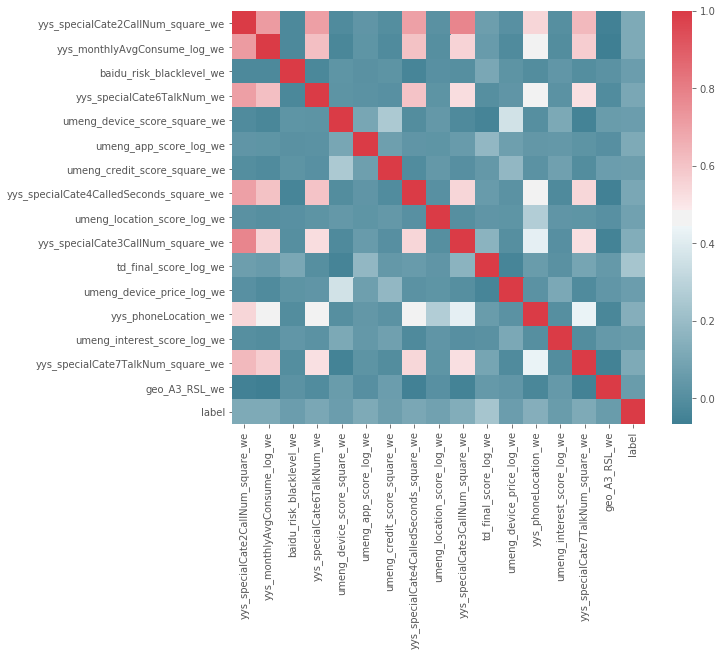

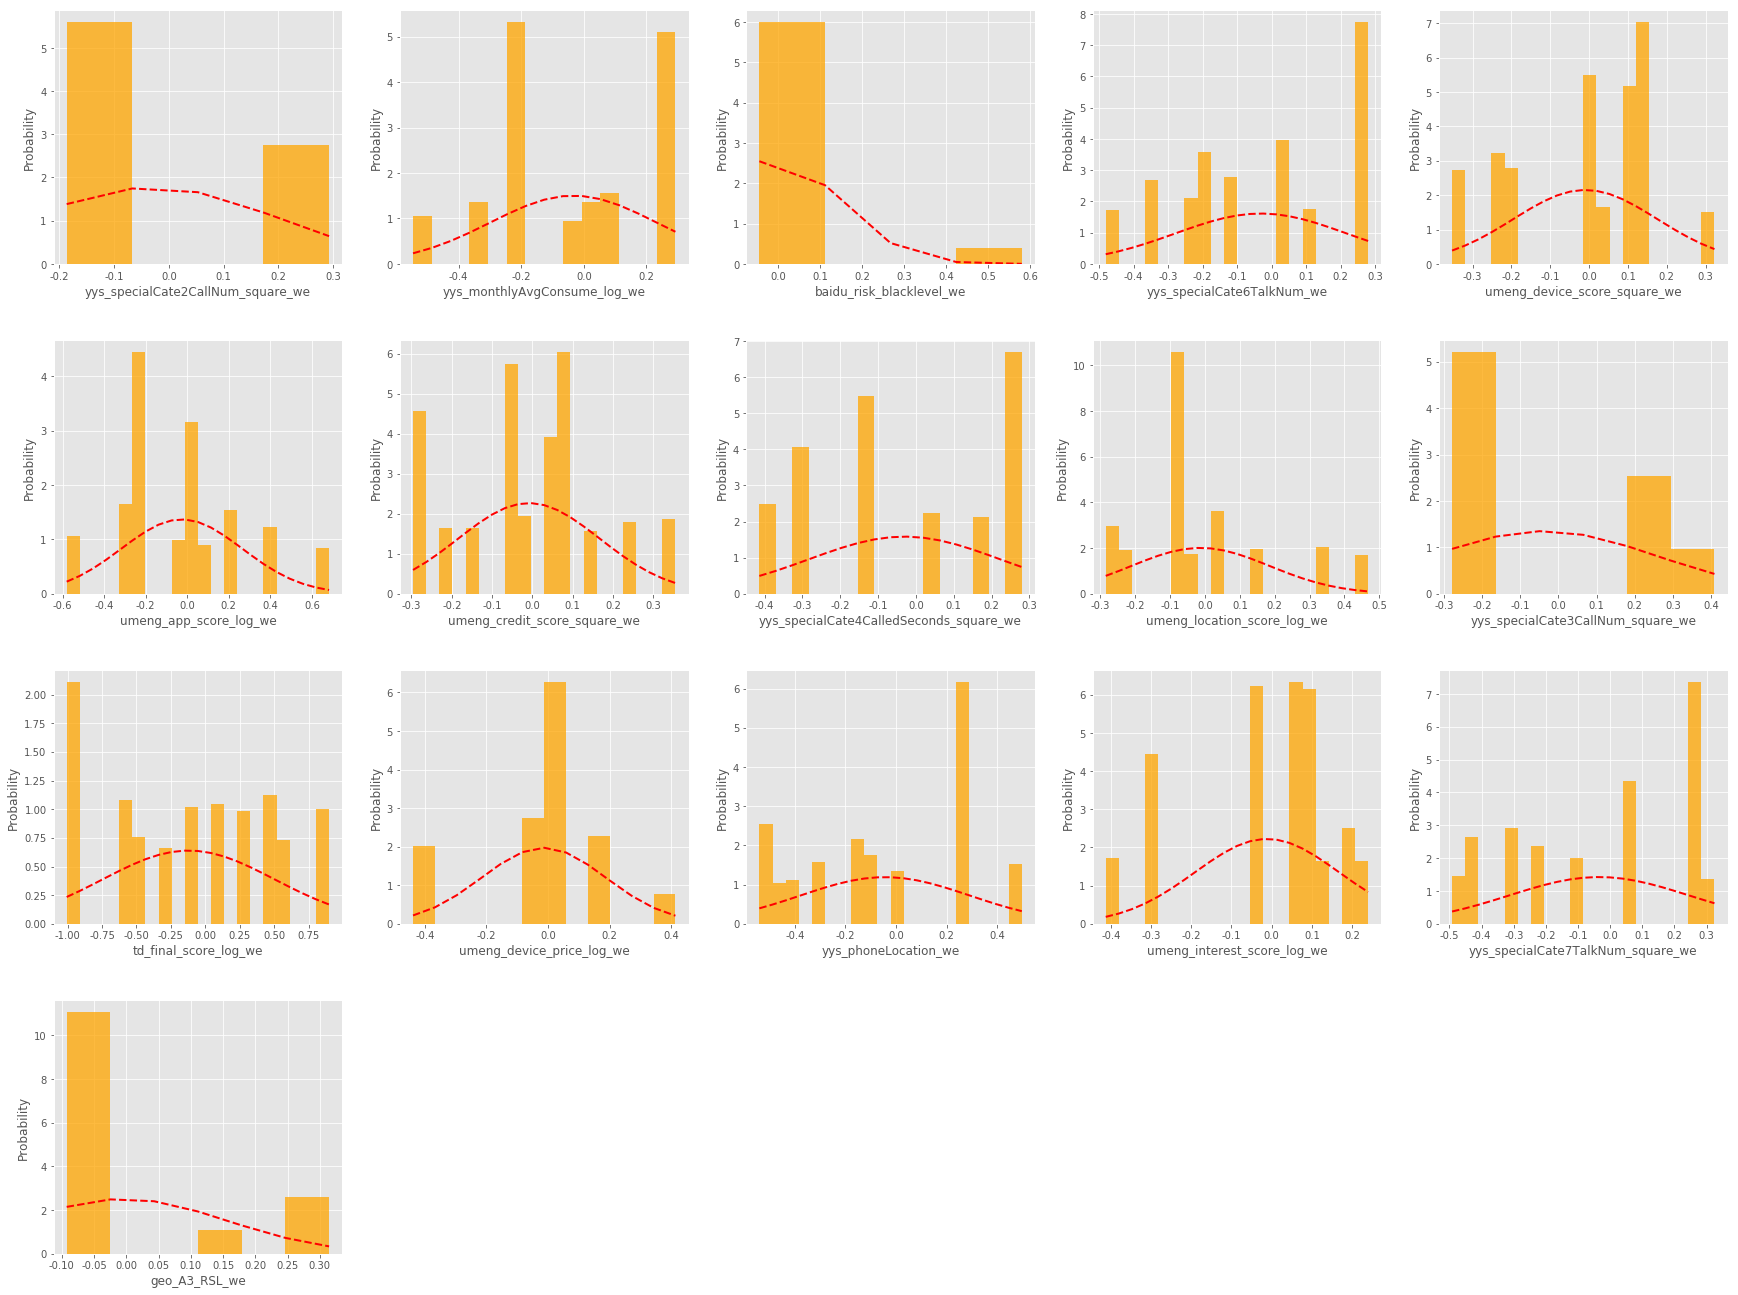

In [34]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################11. FEATURE EVALUATION  ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

print_stype_line();
print('FEATURE EXPLORATION MODULE IS PROCESSING');
print_stype_line()

# Calculate vifs and correlations of columns in the dataframe
df = pd.concat([df_tr, df_va, df_te], axis=0)
vif, _ = get_vif_cor(df, target, plot=True)

print('\n' + '_ ' * 60 + ' ');
print("Vif of features")
print(vif)
#--------------------------------------------------------------------------------------------------#
print('\n' + '_ ' * 60 + ' ');
print("plot histograms of features")

# : params bins: number of bins
plot_hist_all(df, target, bins=10)


## MODEL TRAINING

In [35]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################   12. MODEL TRAINING   ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################
# columns used to train models
col = [i for i in df_tr.columns if i not in [label] + exclude_list + target]

x = pd.concat([df_tr[col], df_va[col], df_te[col]], axis=0)
y = pd.concat([df_tr[label], df_va[label], df_te[label]], axis=0)

print_stype_line();print('MODEL SELECTION MODULE IS PROCESSING');print_stype_line()
best_model, best_model_params, score_dict, params_dict = model_selection(x, y, init_points=5, n_iter=10, acq='ei', cv=5,
                                                                         random_state=2019)



########################################################################################################################
########################################################################################################################

MODEL SELECTION MODULE IS PROCESSING

########################################################################################################################
########################################################################################################################

Apply bayesian optimization to XGBoost model

|   iter    |  target   |   alpha   | colsam... |    eta    |   gamma   |  lambdA   | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7057   |  60.16    |  0.2405   |  0.2314   |  0.1961   |  10.42    |  6.944    |  6.018    |  0.8721   |
|  2        |  0.7108   |  45.5     |  0.3599   |  0.444    |  

|  12       |  0.6635   |  0.001    |  687.4    |
|  13       |  0.7034   |  0.007762 |  919.0    |
|  14       |  0.652    |  0.001    |  422.8    |
|  15       |  0.6847   |  0.00402  |  527.0    |
Best combination of parameters are shownn as below
 {'base_estimator': None, 'algorithm': 'SAMME.R', 'n_estimators': 999, 'learning_rate': 0.042567726730105726}

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

Apply bayesian optimization to GBDT model

|   iter    |  target   | learni... | max_depth | min_im... | min_sa... | min_sa... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.6816   |  0.4631   |  30.59    |  0.000134 |  0.2101   |  22.75    |  413.6    |  0.4436   |
|  2        |  0.5      |  0.2911   |  1.286    |  0.000127 |  0.1824   |  10.73    |  953.7    |  0.304    |
|  3        |  0.6807   |  0.7548

|  8        |  0.6764   |  39.49    |  0.7426   |  0.2172   |  2.059    |  549.7    |
|  9        |  0.682    |  2.33     |  0.999    |  0.01     |  2.0      |  636.8    |
|  10       |  0.6881   |  39.93    |  0.5258   |  0.1085   |  2.032    |  631.0    |
|  11       |  0.6742   |  1.0      |  0.999    |  0.01     |  2.0      |  168.1    |
|  12       |  0.6754   |  1.0      |  0.999    |  0.1383   |  40.0     |  168.2    |
|  13       |  0.5      |  39.98    |  0.1321   |  0.4828   |  27.21    |  169.0    |
|  14       |  0.6761   |  1.0      |  0.999    |  0.1726   |  2.0      |  1e+03    |
|  15       |  0.5      |  26.92    |  0.6304   |  0.3913   |  2.103    |  597.0    |
Best combination of parameters are shownn as below
 {'n_jobs': -1, 'verbose': 0, 'n_estimators': 586, 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 0.01, 'max_features': 0.999}

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

In [36]:
# if best model is lr model, run this
LR_PARAMS = {'print':True, 'equation_file':lr_model_equation_file, 'model_summary_file':lr_model_summary_file, 'vif':vif}

In [37]:
# train the final model
model, pred_train_value, pred_val_value, pred_test_value = model_toolkit('lr', df_tr[col], df_tr[label],
                                                                         x_val=df_va[col], y_val=df_va[label],
                                                                         x_test=df_te[col], xgb_params=None,
                                                                         make_prediction=True, **LR_PARAMS)


                                     Results: Logit
Model:                      Logit                   Pseudo R-squared:        0.106      
Dependent Variable:         label                   AIC:                     6524.5605  
Date:                       2019-02-15 17:52        BIC:                     6640.5901  
No. Observations:           6804                    Log-Likelihood:          -3245.3    
Df Model:                   16                      LL-Null:                 -3630.2    
Df Residuals:               6787                    LLR p-value:             1.6468e-153
Converged:                  1.0000                  Scale:                   1.0000     
No. Iterations:             6.0000                                                      
----------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------

## MODEL EVALUATION

          auc      ks  threshold pass_rate missing_negative_rate
train  0.7248  0.3420     0.2473     62.4%                 13.0%
val    0.6650  0.2471     0.2303     58.9%                 14.9%
test   0.7162  0.4017     0.1191     51.1%                  1.9%
cutpoints derived from train set are  0.01581775191599024, 0.0688841455317148, 0.09703080899596496, 0.12509538282693292, 0.15881180156222519, 0.1931400526529986, 0.2354053625155562, 0.28743844996666346, 0.3462336855618878, 0.434837705409283, 0.8116943199503691


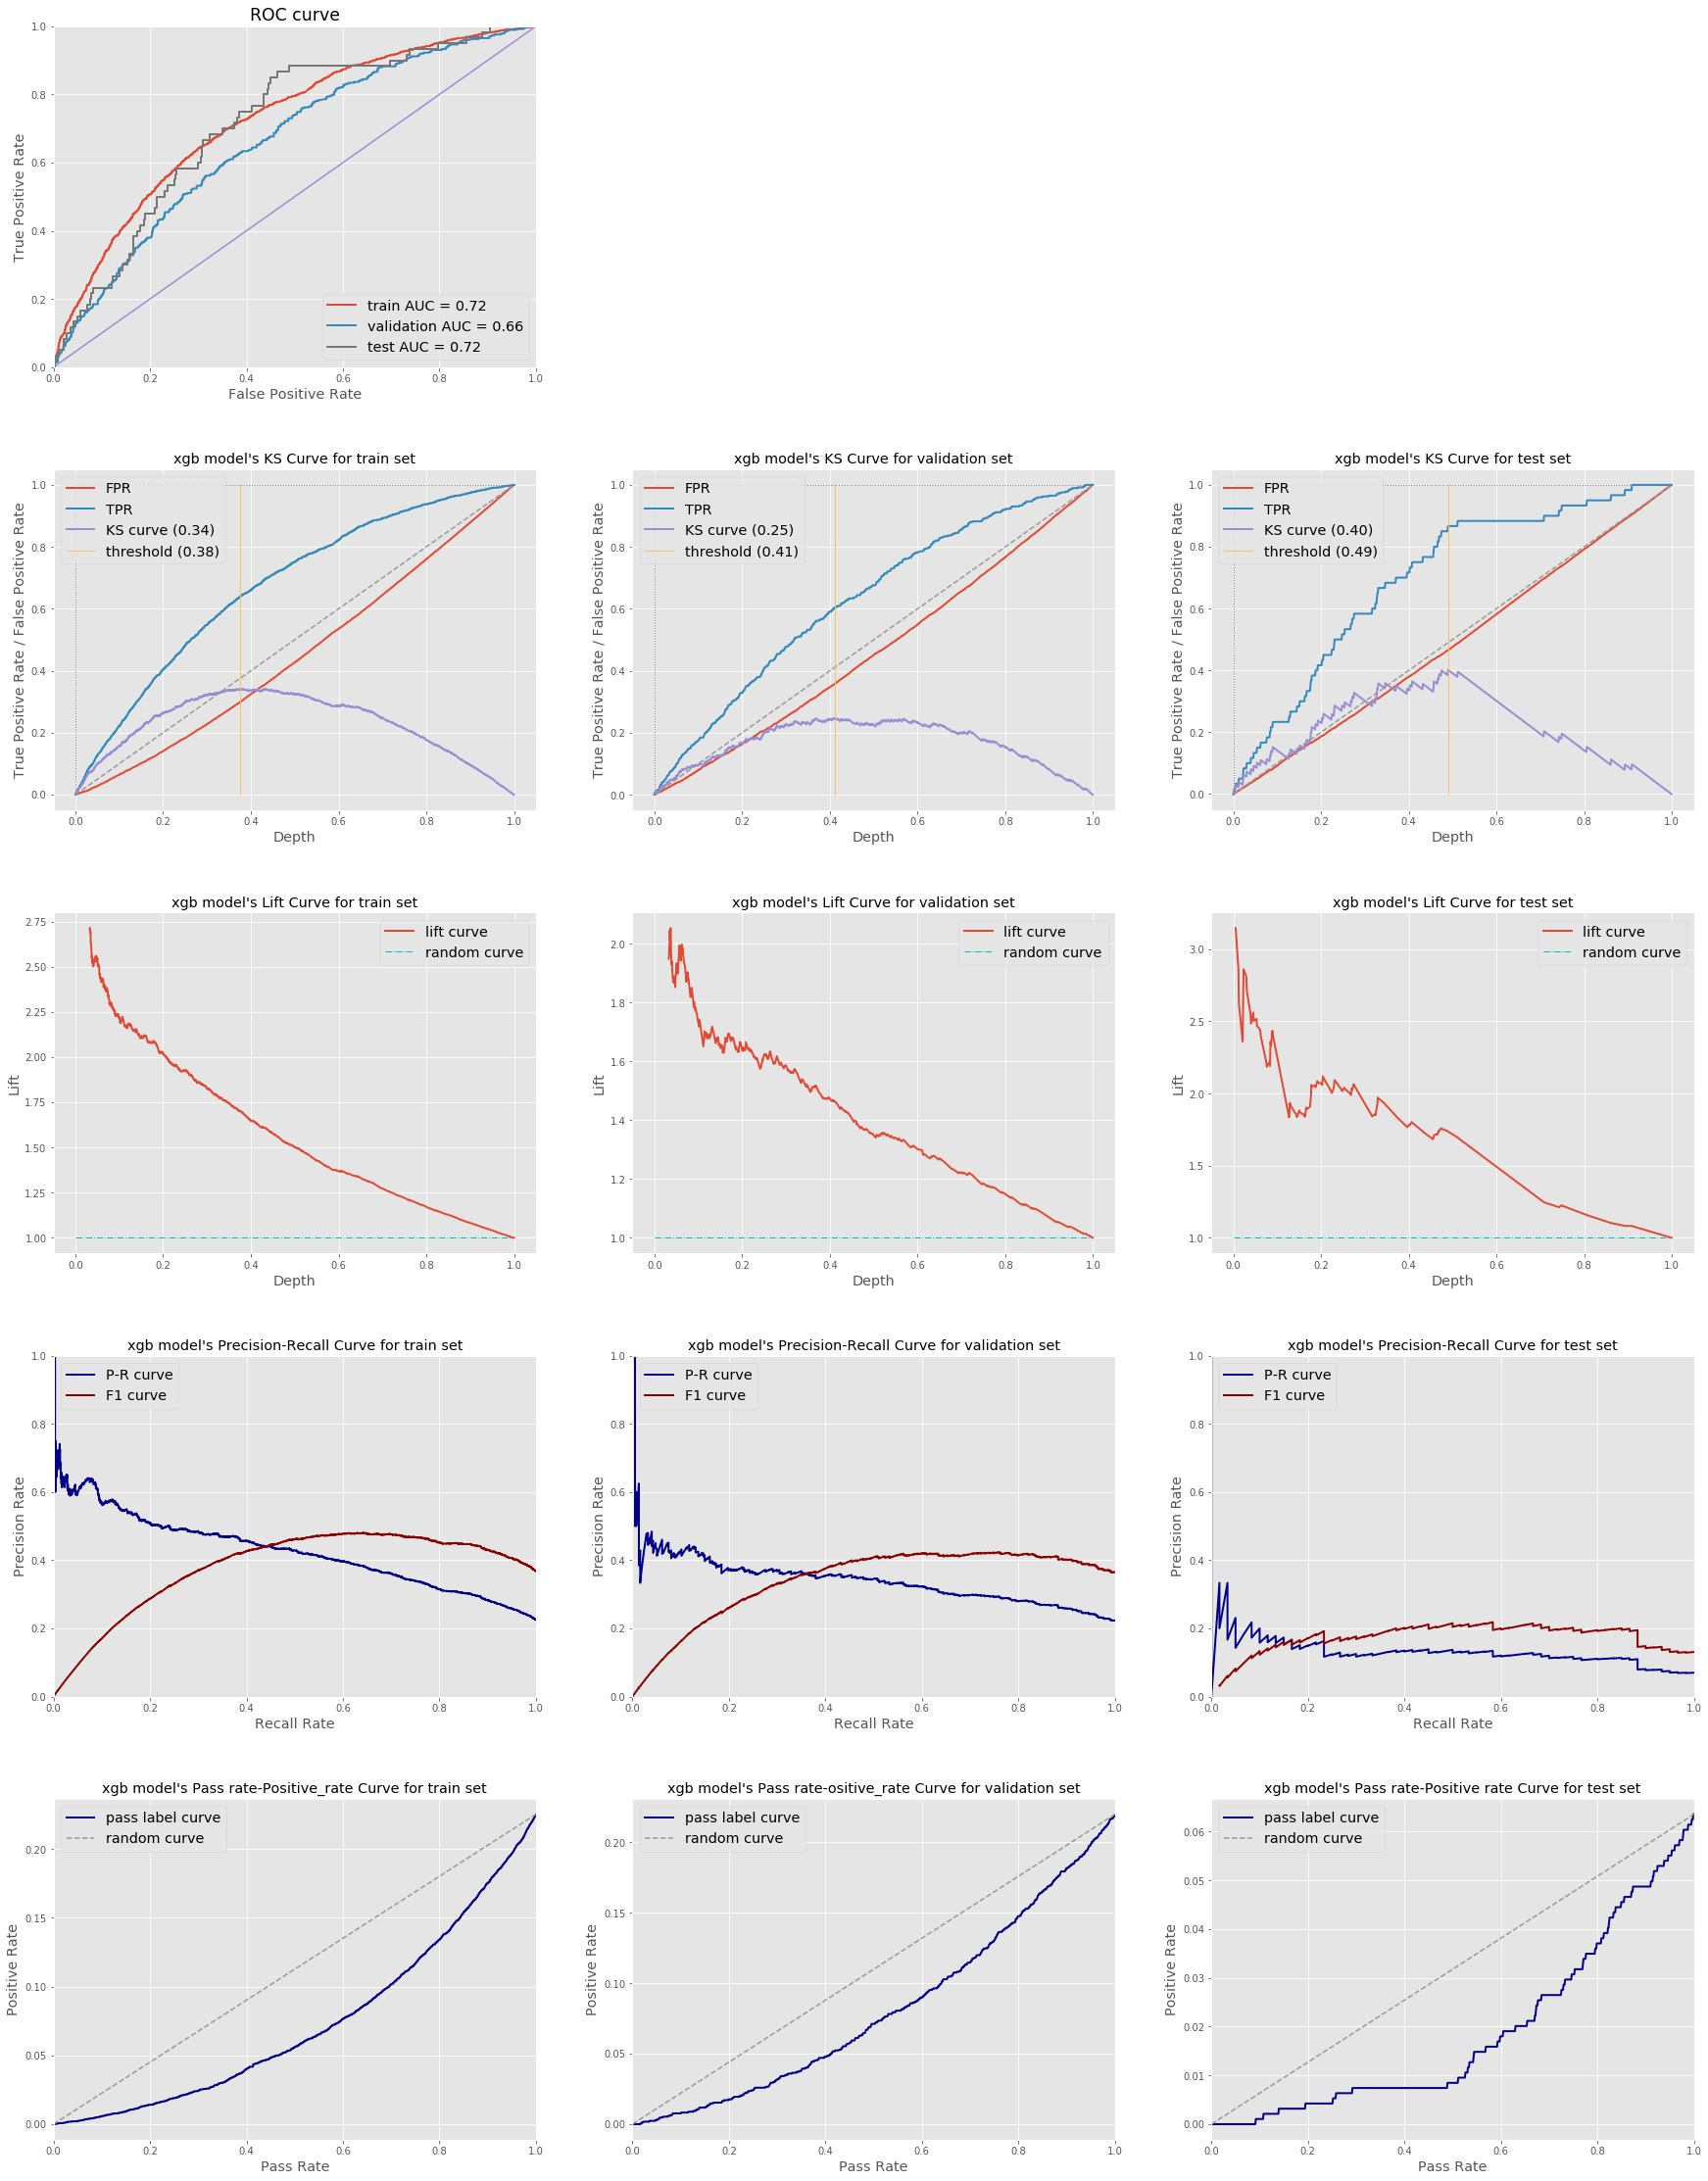

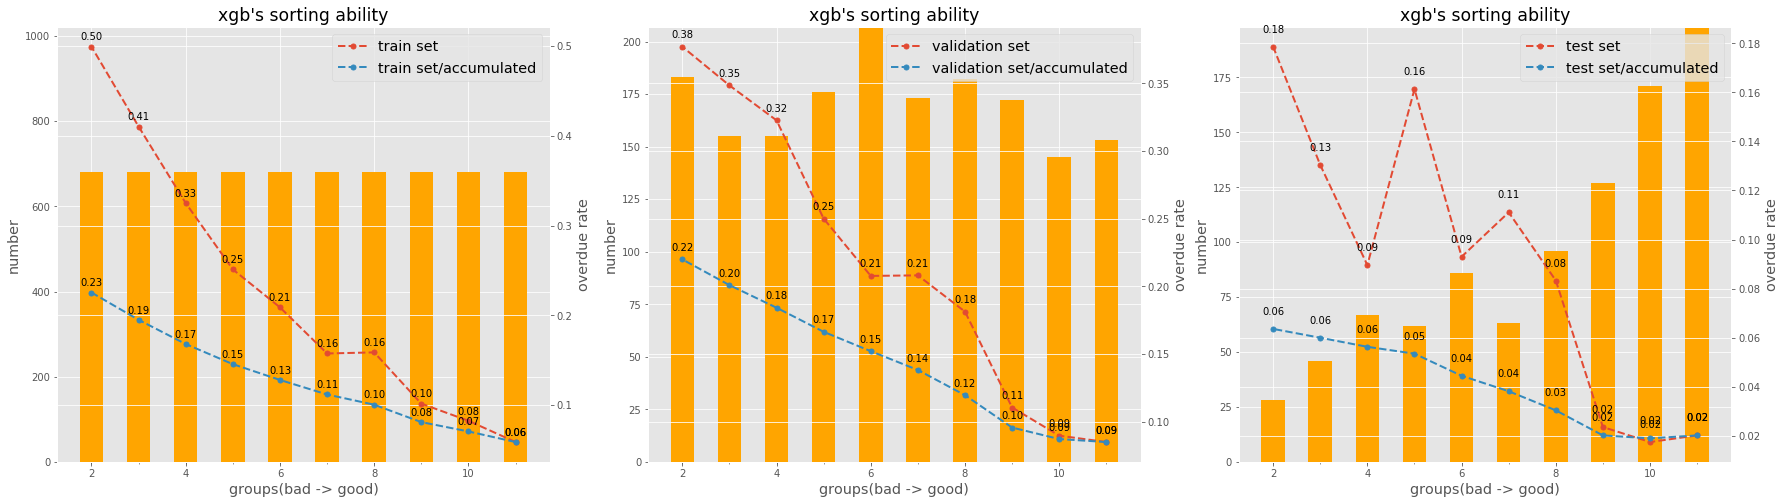

In [38]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################  13. MODEL EVALUATION  ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

tr, va, te = plot_all_figures(pred_train_value, df_tr[label], pred_val_value, df_va[label],
                              pred_test_value=pred_test_value,
                              real_test_label=df_te[label], pos_label=1)
